In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import pickle as pkl
import os

import statsmodels.formula.api as smf
import seaborn as sns
import pandas as pd
import numpy as np

from auxiliary import *

np.random.seed(123)

###  Conditioning ot balance and conditioning to adjust

There exists only one back-door path $D \leftarrow S \leftrightarrow X \rightarrow Y$ and both $S$ nor $X$ are observable. Thus, we have a choice to condition on either one of them.

<img src="material/conditioning_balance_adjust.png" height=300 width=300 />

* $X$, regression estmiator, adjustment-for-other-causes conditioning strategy
* $S$, matching estimator, balancing conditioning strategy

**Agenda**

* Matching as conditioning via stratification
* Matching as weighting
* Matching as data analysis algorithm

**Fundamental concepts**

* stratification of data
* weighting to achieve balance
* propensity scores

**Views on matching**

* method to form quasi-experimental constrasts by sampling comparable treatment and control cases
* as a nonparametric method of adjustment fro treatment assignment patterns

## Matching as conditioning via stratificaton

Individuals withing groups determined by $S$ are entirely indistinguishable from each other in all ways except 

* observed treatment status

* differences in potential outcomes that are independent of treatment status

More formally,

\begin{align*}
E[Y^1 \mid D = 1, S] = E[Y^1 \mid D = 0, S] \\
E[Y^0 \mid D = 0, S] = E[Y^0 \mid D = 0, S]
\end{align*}

implied by ...

* treatment assignment is ignorable
* selection on observables

**ATC**

\begin{align*}
E[\delta \mid D = 0, S] & = E[Y^1 - Y^0 \mid D = 0, S] \\
                        & = E[Y^1 \mid D = 0, S] - E[Y^0 \mid D = 0, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 0, S] \\
                        & = E[Y \mid D = 1, S] - E[Y \mid D = 0, S] \\
\end{align*}

**ATT**
\begin{align*}
E[\delta \mid D = 1, S] & = E[Y^1 - Y^0 \mid D = 1, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 1, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 0, S] \\
                        & = E[Y \mid D = 1, S] - E[Y \mid D = 0, S] \\
\end{align*}

<img src="material/matching_demonstration_one.png" height=300 width=300 />

Let's study these idealized conditions for a simulated dataset.

In [2]:
df = get_sample_matching_demonstration_1(num_agents=10000)
df[['Y', 'D', 'S']].head()

,Y,D,S
0,7.047903,1,2
1,11.651437,0,3
2,13.795799,1,3
3,5.133260,0,2
4,5.380809,0,2


In [3]:
print('The true average treatment effect is {:5.3f}'.format((df['Y_1'] - df['Y_0']).mean()))

The true average treatment effect is 2.647


In [4]:
stat = df['Y'][df['D'] == 1].mean() - df['Y'][df['D'] == 0].mean()
print('The naive estimate is {:5.3f}'.format(stat))

The naive estimate is 5.847


What to do?

In [5]:
df.groupby(['S', 'D'])['Y'].mean()

S  D
1  0     2.019014
   1     4.026830
2  0     6.017456
   1     8.001276
3  0     9.977920
   1    13.980587
Name: Y, dtype: float64

Note that the observed outcomes within each stratum correspond to the averate potential outcome within the stratum. We can compute the average treatment effect by looking at the difference within each strata.

In [6]:
stat = (4 - 2) * 0.44 + (8 - 6) * 0.24 + (14 - 10) * 0.32
print('Exploiting perfect stratification, we estimate {:5.3f}'.format(stat))

Exploiting perfect stratification, we estimate 2.640


The ATT and ATC can be computed analogously just by applying the appropriate weights to the strata-specific effect of treatment.

More generally.

\begin{align*}
\{E_N [y_i \mid d_i = 1, s = s_i] - E_N [y_i \mid d_i = 0, s = s_i]\} \\
\xrightarrow{p} E[Y^1 - Y^0\mid S = s] = E[\delta \mid S = s].
\end{align*}
Weighted sums of these stratified estimates can then be taken such as for the unconditional ATE:
\begin{align*}
\sum_s \{E_N[y_i \mid d_i = 1, s_i = s] - E_N[y_i \mid d_i = 0, s_i = s]\} * {\Pr}_N[s_i = s] \\ 
\xrightarrow{p} E[\delta]
\end{align*}


This example shows all of the basic principles in matching estimators that we will discuss in greated detail in this lecture. 

* Treatment and condtrol subjects are matched together in the sense theat they are grouped together into strata.

* An average difference between the outcomes of the treatment and control subjects is estimated, based on a weighting of the strata by common distribution.

### Overlap conditions

In [7]:
df = get_sample_matching_demonstration_2(num_agents=1000)
df[['Y', 'D', 'S']].head()

,Y,D,S
0,2.070880,0,1
1,14.946911,1,3
2,6.841465,1,2
3,10.765369,0,3
4,7.396803,1,2


In [8]:
df.groupby(['S', 'D'])['Y'].mean() # Maybe with categorial variables to slaos show missing?

S  D
1  0     1.979601
2  0     6.000293
   1     7.992382
3  0    10.100675
   1    14.066494
Name: Y, dtype: float64

What can we do?

## Matching as weighting


As indicated by the stylized example, there are often many strata where we do not have treated and control individuals available at the same time.

$\rightarrow$ combine information from different strata with the same propensity score $p$

**Definition** The estimated propensity score is the estimated probability of taking the treatment as a function of variables that predict treatment assignment, i.e. $\Pr[D = 1 \mid S]$.

$\rightarrow$ stratifying on the propensity score itself ameliorates the sparseness problem because the propensity score can be treated as a single stratifying variable.

In [9]:
df, counts = get_sample_matching_demonstration_3()
df.head()

,a,b,d,y,y_1,y_0,p
0,0.01,0.03,1,99.128694,99.128694,96.161890,0.332700
1,0.01,0.05,1,100.514124,100.514124,103.667086,0.335369
2,0.01,0.05,0,99.861575,94.614633,99.861575,0.335369
3,0.01,0.09,0,97.367721,99.070555,97.367721,0.340740
4,0.01,0.13,0,98.616631,95.668702,98.616631,0.346151


We will now look at different ways to construct estimates for the usual causal parameters. So, we first compute their true counterparts.

In [10]:
true_effects = dict()
true_effects['att'] = (df['y_1'] - df['y_0'])[(df['d'] == 1)].mean()
true_effects['atc'] = (df['y_1'] - df['y_0'])[(df['d'] == 0)].mean()
true_effects['ate'] = (df['y_1'] - df['y_0']).mean()

In [11]:
print('The true estimate of the average causal effect is {:5.3f}'.format(true_effects['ate']))

stat = df['y'][df['d'] == 1].mean() - df['y'][df['d'] == 0].mean()
print('The naive estimate of the average causal effect is {:5.3f}'.format(stat))

The true estimate of the average causal effect is 4.486
The naive estimate of the average causal effect is 4.881


How about the issue of sparsity on the data?

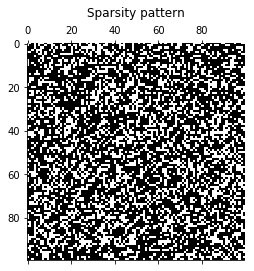

In [12]:
get_sparsity_pattern_overall(counts)

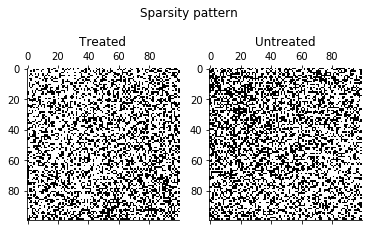

In [13]:
get_sparsity_pattern_by_treatment(counts)

How does the propensity score $P(D = 1\mid S)$ as a function of the observables $(a, b)$ look like?

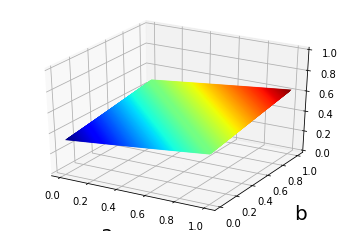

In [14]:
plot_propensity_score(a_grid, b_grid)

We still must be worried about common support.

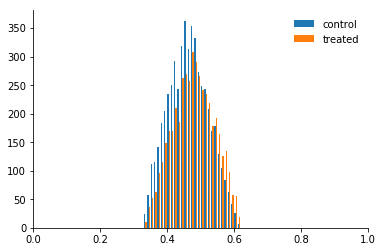

In [15]:
get_common_support(df)


\begin{align*}
\hat{\delta}_{\text{ATT, weight}} \equiv \left( \frac{1}{n^1}\sum_{i:d_i = 1} y_i\right) 
- \left(\frac{\sum_{i:d_i=0}\hat{r}_i y_i}{\sum_{i:d_i = 0} \hat{r}_i}\right)
\end{align*}

\begin{align*}
\hat{\delta}_{\text{ATC, weight}} \equiv 
\left(
\frac{\sum_{i: d_i = 1}\frac{y_i}{\hat{r}_i}}{\sum_{i: d_i = 1}\frac{1}{\hat{r}_i}}
\right)
- \left(\frac{1}{n^0} \sum_{i: d_i = 0} y_i\right) 
\end{align*}

\begin{align*}
\hat{\delta}_{\text{ATE, weight}} \equiv \left(\frac{1}{n}\sum_{i}d_i\right) \hat{\delta}_{\text{ATT, weight}} +  \left(1 - \frac{1}{n}\sum_{i}d_i\right) \hat{\delta}_{\text{ATC, weight}}
\end{align*}

In [16]:
def get_att_weight(df, prob):
    
    weights = get_odds(prob)
    is_untreated = (df['d'] == 0)
    is_treated = (df['d'] == 1)

    value, weights = df['y'][is_untreated], weights[is_untreated]
    att = df['y'][is_treated].mean() - np.average(value, weights=weights)
    
    return att

def get_ate_weight(df, prob):
    
    share_treated = df['d'].value_counts(normalize=True)[1]

    atc = get_atc_weight(df, prob)
    att = get_att_weight(df, prob)

    return share_treated * att + (1.0 - share_treated) * atc
    
    
def get_atc_weight(df, prob):
    
    weights = get_inv_odds(prob)

    is_untreated = (df['d'] == 0)
    is_treated = (df['d'] == 1)

    value, weights = df['y'][is_treated], weights[is_treated]
    att = np.average(value, weights=weights) - df['y'][is_untreated].mean()
    
    return att

def get_odds(p):
    return p / (1 - p)

def get_inv_odds(p):
    return (1 - p) / p

# Calculate the ATT using the true odds ratio
prob = df['p']
att_true = get_att_weight(df, prob)
atc_true = get_atc_weight(df, prob)
ate_true = get_ate_weight(df, prob)

# Calculate the ATT using a correctly specified estimate of the propensity score
p = smf.logit(formula='d ~ a + b + a * b', data=df).fit().predict()
att_correct = get_att_weight(df, p)
atc_correct = get_atc_weight(df, p)
ate_correct = get_ate_weight(df, p)

# Calculate the ATT using the misspecified probensity score
prob = smf.logit(formula='d ~ a + b', data=df).fit().predict()
att_misspecified = get_att_weight(df, p)
atc_misspecified = get_atc_weight(df, p)
ate_misspecified = get_ate_weight(df, p)

print(att_misspecified, att_correct, att_true, true_effects['att'])
print(atc_misspecified, atc_correct, atc_true, true_effects['atc'])
print(ate_misspecified, ate_correct, ate_true, true_effects['ate'])

Optimization terminated successfully.
         Current function value: 0.683323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683523
         Iterations 4
4.616014863986976 4.616014863986976 4.6148629074157554 4.632119347874727
4.401021493885821 4.401021493885821 4.380175224021329 4.359052539557583
4.501128457069605 4.501128457069605 4.4894524136862906 4.486200129802138


## Matching as data analysis algorithm

\begin{align*}
\hat{\delta}_{\text{ATT, match}} = \frac{1}{n^1} \sum_i \left[
(y_i \mid d_i = 1) - \sum_j \omega_{i, j} (y_j \mid d_j =0 )
\right]
\end{align*}

\begin{align*}
\hat{\delta}_{\text{ATC, match}} = \frac{1}{n^0} \sum_j \left[
(y_j \mid d_j = 0) - \sum_i \omega_{j, i} (y_i\mid d_i = 1)
\right]
\end{align*}


### Basic variants of matching algorithms

* exact matching

* nearest-neighbor, caliper, and radius matching

* interval matching

* kernel matching

**kernel matching**

\begin{align*}
\omega_{i, j} = \frac{G\left(\frac{\hat{p_j} - \hat{p_i}}{a_n}\right)}{\sum_j G\left(\frac{\hat{p_j} - \hat{p_i}}{a_n}\right)}
\end{align*}

### Tutorial

<img src="material/catholic_school_example.png" height=300 width=300 />

In [17]:
df = get_sample_matching_demonstration_4()
df.head()

,y,treat,asian,hispanic,black,natamer,urban,neast,ncentral,south,...,ncentralblack,southblack,twohisp,neasthisp,ncentralhisp,southhisp,yt,yc,dshock,d
0,124.820446,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,128.815053,124.820446,-2.189125,3.994607
1,100.389487,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,104.467199,100.389487,-2.517059,4.077712
2,101.244684,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,105.924622,101.244684,-1.307933,4.679938
3,99.257258,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,97.574659,99.257258,-7.004977,-1.682599
4,92.977159,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,98.577122,92.977159,-0.236095,5.599963


In [18]:
example_covariates = ['black', 'urban', 'test']
df[example_covariates].describe()

,black,urban,test
count,10000.000000,10000.00000,10000.000000
mean,0.096100,0.38910,-0.002229
std,0.294743,0.48757,0.991747
min,0.000000,0.00000,-3.862709
25%,0.000000,0.00000,-0.676463
50%,0.000000,0.00000,-0.006683
75%,0.000000,1.00000,0.660488
max,1.000000,1.00000,3.722783


In [19]:
stat = (df['yt'] - df['yc'])[df['treat'] == 1].mean()
print('The true ATT is {:5.3f}'.format(stat))

The true ATT is 6.957


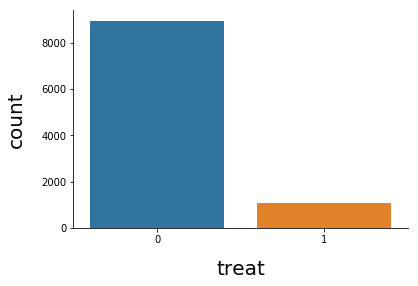

In [20]:
sns.countplot(x='treat', data=df)

Optimization terminated successfully.
         Current function value: 0.252643
         Iterations 8


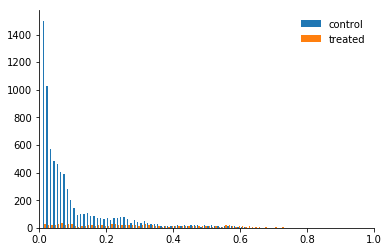

In [21]:
def nearest_neighbor_algorithm_for_att(df, check_store=True):
    
    if check_store:
        if os.path.exists('matched.ngbr.pkl'):
            return pkl.load(open('matched.ngbr.pkl', 'rb'))
    
    # We select all treated individuals
    df_control = df[df['treat'] == 0]
    df_treated = df[df['treat'] == 1]
    
    rslt = np.full((df_treated.shape[0], 11), np.nan)
    
    # We now iterate over all treated individuals and 
    # find a set of neighbors.
    for i, (index, row) in enumerate(df_treated.iterrows()):
        
        y, p, b, u, t = row[['y', 'p', 'black', 'urban', 'test']]
        df_control = df_control.assign(distance = np.abs(df_control['p'] - p))
        
        idx_ngbr = df_control['distance'].idxmin()
        y_ngbr, p_ngbr = df_control.loc[idx_ngbr, ['y', 'p']]
        b_ngbr, u_ngbr = df_control.loc[idx_ngbr, ['black', 'urban']]
        t_ngbr = df_control.loc[idx_ngbr, ['test']]

        rslt[i] = [i, y, y_ngbr, p, p_ngbr, b, b_ngbr, u, u_ngbr, t, t_ngbr]

    columns = ['count', 'y', 'y_ngbr', 'p', 'p_ngbr', 'b', 'b_ngbr']
    columns += ['u', 'u_ngbr', 't', 't_ngbr']
    df = pd.DataFrame(rslt, columns=columns)
    
    pkl.dump(df, open('matched.ngbr.pkl', 'wb'))
    
    return df

df = get_sample_matching_demonstration_4()
df['p'] = get_propensity_scores_matching_demonstration_4(df)
get_common_support(df, 'treat')

In [22]:
df_matched = nearest_neighbor_algorithm_for_att(df, False)

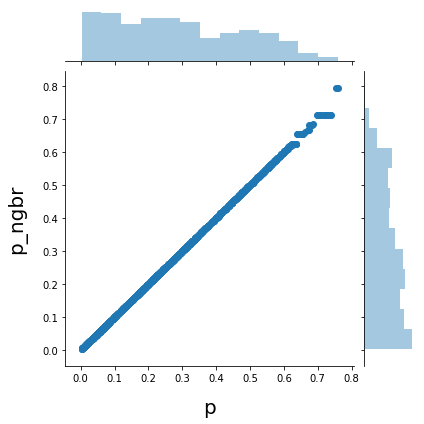

In [23]:
sns.jointplot('p', 'p_ngbr', df_matched)

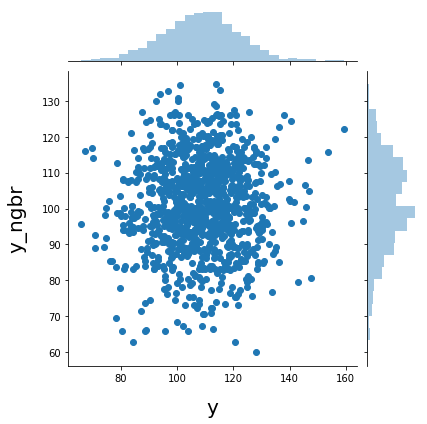

In [24]:
sns.jointplot('y', 'y_ngbr', df_matched)

How do our covariantes balance across treatment status?

In [27]:
df.groupby('treat')[example_covariates].mean().T

treat,0,1
black,0.092646,0.125475
urban,0.337953,0.824144
test,-0.039018,0.310690


We now want to revisit the balancing of covariates.

In [29]:
rename = {'y_ngbr': 'y', 'p_ngbr': 'p', 'b_ngbr': 'b', 'u_ngbr': 'u', 't_ngbr': 't'}

df_control = df_matched[['y_ngbr', 'p_ngbr', 'b_ngbr', 'u_ngbr', 't_ngbr']]
df_control = df_control.rename(columns=rename)
df_control = df_control.assign(treat=0)

df_treated = df_matched[['y', 'p', 'b', 'u', 't']]
df_treated = df_treated.assign(treat=1)

df_subset = pd.concat([df_treated, df_control])
df_subset.groupby('treat').mean().T

treat,0,1
y,101.210034,108.445596
p,0.290813,0.290772
b,0.141635,0.125475
u,0.826996,0.824144
t,0.308589,0.310690
